So far in `04` and `06` we used `TinyVGG` model and a pretrained model and compared their results by comparing their metrics. What is we want to run a **few models at once**. That's where **Experimental Tracking** comes into play. It helps in tracking the machine learning experiments and let us know what works and what doesn't.

The ML experiments are tracked by,
1. python dictionary - As done using `results` but will get out of hand if huge number of experiments are conducted.
2. TensorBoard - extension built into pyTorch
3. Wights and Biases Experiment Tracking
4. MLFlow

Due to the integration with pyTorch, in this notebook we will be using `tensorBoard` to track our experiments.

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchinfo import summary


import matplotlib.pyplot as plt
import os
import zipfile
from pathlib import Path
import requests

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Get data

In [2]:
# data path
data_path = Path("../Dataset/")

# image path
img_path = data_path / "pizza_steak_sushi"

if img_path.is_dir():
    print("Folder already exists, skipping download ...")
else:
    print("Folder doesn't exist, creating one ...")
    
    # create image folder
    img_path.mkdir(parents=True)

    # download the data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data ...")

        # write data
        f.write(request.content)

    # extract zip file
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as f:
        print("Unzipping the file ...")

        # extract file
        f.extractall(img_path)

    # delete zipfile
    os.remove(data_path / "pizza_steak_sushi.zip")

Folder already exists, skipping download ...


In [3]:
# Setup Dirs
train_dir = img_path / "train"
test_dir = img_path / "test"

# 2. Create dataset and dataloders
Since we are using a pretrained model, we need to transform our custom data in a way the data used for training the model was sent.
1. Resize image to 224X224
2. Images need to be normliased in range of [0,1] with mean = [0.485,0.456,0.406] and standard deviation = [0.229,0.224,0.225]. Three values since there are three channels. Will perform z-transform.
3. Convert image to tensor

A better way to get the same transforms performed in the pretrained model is to use `torchvision.models` function. The trade-off of using this transforms is the lack of customisation.

In [4]:
from torchvision import transforms
from torchvision.models import EfficientNet_B0_Weights # load an architecture

In [5]:
# get pretrained weigths
wts = EfficientNet_B0_Weights.DEFAULT # default : gives the best performance weights

# get the transforms used
transf_pretrained_model = wts.transforms()
transf_pretrained_model

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
# create dataset and dataloaders using pretrained transforms
from turning_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataset_dataloader(train_dir=train_dir, test_dir=test_dir,
                                                                                      transform=transf_pretrained_model, 
                                                                                      batch_size=32) # mini-batch of 32
class_names

['pizza', 'steak', 'sushi']

# 3. Getting pretrained model
As we saw in `04` and `05` notebooks that our model performance was relatively poor. That's why we are leveraging transfer learning. The better performing model may sometimes be `too big` on some devices. eg:mobile devices, therefore some trade-off needs to be there.

Therefore, there will always be a,
**performance vs speed vs size tradeoff**

`EfficientNet_B0_Weights` is the model we are going to be using in our case. Other model performance can be checked by experimentation.

In [29]:
wts = EfficientNet_B0_Weights.DEFAULT # default : gives the best performance weights

# sending the weights to the model
model = torchvision.models.efficientnet_b0(weights=wts).to(device)

# 4. Freezing base mode and changing the output layer

Since the output layer is problem specific, it needs to be altered. This is done by `freezing base layers` and then `adjust output layers` (also called head/classifier layer) to suit our need.

The model above comes with `1000` output classes since there are 1000 classes in imageNet. For our classification,we need only `3` output classes.

1. Freeze all the layers (set it to untrainable) - set `requirees_grad` to `False`

In [30]:
# freeze all the parameters except classifier layer
for param in model.features.parameters(): # get parameters of each layer
    param.requires_grad = False

In [31]:
# change the output layer (classifier layer)
torch.manual_seed(42)

# out classes size
n_out_classes = len(class_names)

from torch import nn
# create the classifier layer
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), # keep the dropout as was in original classifier layer
                                 nn.Linear(in_features=1280,
                                           out_features=n_out_classes,
                                           bias=True)).to(device)

# 5. Training and tracking
Previously we were tracking the experiment results using `dictionaries`, so now we need to tune our `train()` function inorder to use `torch.utils.tensorboard.SummaryWriter()` which saves various parts of our model's training progress to file (log). This is saved in `tensorBoard format`.

In [10]:
# create loss functio nadn optimiser
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
from torch.utils.tensorboard import SummaryWriter

In [12]:
# create a writer instance with default settings
writer = SummaryWriter()

### a. modify train() function

In [13]:
from turning_modular.engine import train_step, test_step
from tqdm import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn : torch.float32,
          optimizer: torch.optim.Optimizer,
          epochs:int, device:torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter):

    '''Trains and tests model for given number of epochs
    
    Args:
        model: pytorch model to be trained and tested
        train_data_loader: training dataloader instance of data
        test_data_loader: testing dataloader instance of data
        loss_fn    : lost function to be minimised
        optimizer  : optmizer to minimize the loss function
        epochs     : number of times a data is to be used for training
        device     : cpu (or) cuda
        writer     " SummaryWriter() instance to log model results

    returns:
        dictionary of training and testing loss and accuracy'''

    results = {"train_loss": [], "train_acc": [],
               "test_loss": [], "test_acc": []}  

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, train_dataloader=train_dataloader,
                                         loss_fn=loss_fn, optim=optimizer,
                                         device=device)
        test_loss, test_acc = test_step(model=model, test_dataloader=test_dataloader,
                                      loss_fn=loss_fn, device=device)

        print(f"Model: {model.__class__.__name__} | train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}%")

        print(f"Model: {model.__class__.__name__} | Test loss: {test_loss:.4f}, test accuracy: {test_acc}% \n")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # experiment tracking
        if writer:
            # add train and test loss results to summaryWriter
            writer.add_scalars(main_tag = "Loss",
                              tag_scalar_dict={"train_loss": train_loss, 
                                               "test_loss": test_loss}, 
                              global_step=epoch)
    
            # add accuracy results to summaryWriter
            writer.add_scalars(main_tag = "Accuracy",
                              tag_scalar_dict={"train_acc": train_acc, 
                                               "test_acc": test_acc}, 
                              global_step=epoch)
    
            # Track pytTorch architecture
            writer.add_graph(model=model, 
                             # Pass in an example input
                             input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
            # close the writer
            writer.close()

        else:
            pass

    return results

In [14]:
# train and track the experiment
torch.manual_seed(42)

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optim,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

Will produce results similar to `06 notebook` except here it creates `runs/` directory which stores out model results. Lets visualise the results using tensorBoard

In [15]:
%load_ext tensorboard
%tensorboard --logdir ./runs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# 6. Create helper function to create a custom directory per experiment

In [16]:
%%writefile turning_modular/writer.py

from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str, model_name: str, 
                  extra: str=None):
    '''Creates a SummaryWriter() instance
    Args:
        experiment_name : Name of the experiment
        model_name      : Name of the model
        extra           : Anything extra if required to the directory

    return:
        Instance of SummaryWriter()
    '''

    from datetime import datetime
    import os
    
    # time now
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    return SummaryWriter(log_dir=log_dir)

Overwriting turning_modular/writer.py


# 7. Setting series of experiments

We will instantiate series of experiments and inspects at once. The experiments involve,
* Change number of epochs
* Change number of layers
* Change number of hidden units per layer
* change learning rate
* Different typr of data augmentation
* Different model architecture

An ideal model should give high accuracy but doesn't taken too long to train

In this notebook, we will perform,
1. Different amount of data (10% of each vs 20% of each)
2. torchvision.models.efficientnet_b0 vs torchvision.models.efficientnet_b2 (higher the number, deeper the layer).
3. Different number of epochs (5 vs 10)

Therefore, there will be 2X2X2 = 8 experiments

### a. Download 10% and 20% dataset

The 10% percent is the data that we have been using. Therefore, we download only the 20% data

In [17]:
# data path
data_20_percent_path = Path("../Dataset/")

# image path
img_path = data_20_percent_path / "pizza_steak_sushi_20_percent"

if img_path.is_dir():
    print("Folder already exists, skipping download ...")
else:
    print("Folder doesn't exist, creating one ...")
    
    # create image folder
    img_path.mkdir(parents=True)

    # download the data
    with open(data_20_percent_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading data ...")

        # write data
        f.write(request.content)

    # extract zip file
    with zipfile.ZipFile(data_20_percent_path / "pizza_steak_sushi_20_percent.zip", "r") as f:
        print("Unzipping the file ...")

        # extract file
        f.extractall(img_path)

    # delete zipfile
    os.remove(data_20_percent_path / "pizza_steak_sushi_20_percent.zip")

Folder already exists, skipping download ...


In [18]:
# Download 10 percent and 20 percent training data
train_dir_20 = img_path / "train"

### b. Create dataloader for 20% data

In [19]:
# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataset_dataloader(train_dir=train_dir_20,
    test_dir=test_dir,
    transform=transf_pretrained_model,
    batch_size=32
)

print(f"Number of batches in 10% dataset is {len(train_dataloader)}")
print(f"Number of batches in 20% dataset is {len(train_dataloader_20_percent)}")

Number of batches in 10% dataset is 8
Number of batches in 20% dataset is 15


### c. Getting pretrained model torchvision.models.efficientnet_b2()

In [32]:
# 1. Create an instance of EffNetB2 with pretrained weights
model_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
model_b2 = torchvision.models.efficientnet_b2(weights=model_b2_weights).to(device)

# 2. Freeze the base model layers
for param in model_b2.features.parameters():
    param.requires_grad = False

torch.manual_seed(42)

# 3. Change classfier layer
model_b2.classifier = nn.Sequential(nn.Dropout(p=0.2),
                                 nn.Linear(in_features=1408, out_features=3)
                                ).to(device)

### d. create experiments

In [25]:
# number of epochs
n_epochs = (5,10)

# models
models = ("effnetb0", "effnetb2")

# dataloader dictionary
train_dataloaders = {"data_10_percent": train_dataloader,
                     "data_20_percent": train_dataloader_20_percent}

### e.Training

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%%time
from turning_modular.utils import save_model
from turning_modular import writer

torch.manual_seed(42)

# 1. Keep track of experiment numbers
experiment_number = 0

# 2. Loop through each DataLoader
for dataloader_name, dataloader_val in train_dataloaders.items():

    # 3. Loop through each number of epochs
    for epochs in n_epochs: 

        # 4. Loop through each model
        for model_name in models:

            experiment_number += 1
            print(f"Experiment number: {experiment_number}")
            print(f"Model: {model_name}")
            print(f"DataLoader: {dataloader_name}")
            print(f"Number of epochs: {epochs}")

            # 5. Select the model
            if model_name == "effnetb0":
                model_used = model # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model_used = model_b2

            # 6. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optim   = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 7. Train
            train(model=model_used,
                  train_dataloader=dataloader_val,
                  test_dataloader=test_dataloader, 
                  optimizer=optim,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=writer.create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            # 8. Save model to get the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model_used,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

Experiment number: 1
Model: effnetb0
DataLoader: data_10_percent
Number of epochs: 5


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Model: EfficientNet | train loss: 1.0962 | Train acc: 39.0625%
Model: EfficientNet | Test loss: 0.9144, test accuracy: 59.09090909090909% 



 20%|████████████████▊                                                                   | 1/5 [00:25<01:41, 25.26s/it]

Model: EfficientNet | train loss: 0.9046 | Train acc: 64.4531%
Model: EfficientNet | Test loss: 0.7883, test accuracy: 82.57575757575758% 



 40%|█████████████████████████████████▌                                                  | 2/5 [00:49<01:14, 24.69s/it]

Model: EfficientNet | train loss: 0.8096 | Train acc: 73.4375%
Model: EfficientNet | Test loss: 0.6768, test accuracy: 88.63636363636363% 



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:12<00:47, 23.87s/it]

Model: EfficientNet | train loss: 0.6849 | Train acc: 86.3281%
Model: EfficientNet | Test loss: 0.6739, test accuracy: 80.49242424242425% 



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:33<00:22, 22.84s/it]

Model: EfficientNet | train loss: 0.7080 | Train acc: 72.6562%
Model: EfficientNet | Test loss: 0.6793, test accuracy: 77.36742424242425% 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:55<00:00, 23.05s/it]


Saving model ...
--------------------------------------------------

Experiment number: 2
Model: effnetb2
DataLoader: data_10_percent
Number of epochs: 5


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Model: EfficientNet | train loss: 1.1274 | Train acc: 23.8281%
Model: EfficientNet | Test loss: 1.0754, test accuracy: 39.01515151515151% 



 20%|████████████████▊                                                                   | 1/5 [00:22<01:31, 22.76s/it]

Model: EfficientNet | train loss: 1.1218 | Train acc: 24.2188%
Model: EfficientNet | Test loss: 1.0703, test accuracy: 46.21212121212121% 



 40%|█████████████████████████████████▌                                                  | 2/5 [00:48<01:13, 24.46s/it]

Model: EfficientNet | train loss: 1.1134 | Train acc: 31.6406%
Model: EfficientNet | Test loss: 1.0819, test accuracy: 35.03787878787879% 



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:14<00:50, 25.25s/it]

Model: EfficientNet | train loss: 1.1065 | Train acc: 39.8438%
Model: EfficientNet | Test loss: 1.0812, test accuracy: 38.06818181818182% 



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:36<00:23, 24.00s/it]

Model: EfficientNet | train loss: 1.0973 | Train acc: 39.4531%
Model: EfficientNet | Test loss: 1.0897, test accuracy: 34.090909090909086% 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.13s/it]


Saving model ...
--------------------------------------------------

Experiment number: 3
Model: effnetb0
DataLoader: data_10_percent
Number of epochs: 10


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Model: EfficientNet | train loss: 0.6168 | Train acc: 76.1719%
Model: EfficientNet | Test loss: 0.5255, test accuracy: 88.63636363636363% 



 10%|████████▎                                                                          | 1/10 [00:24<03:40, 24.46s/it]

Model: EfficientNet | train loss: 0.5435 | Train acc: 80.4688%
Model: EfficientNet | Test loss: 0.5363, test accuracy: 88.63636363636363% 



 20%|████████████████▌                                                                  | 2/10 [00:45<03:00, 22.56s/it]

Model: EfficientNet | train loss: 0.4864 | Train acc: 80.8594%
Model: EfficientNet | Test loss: 0.4592, test accuracy: 88.63636363636363% 



 30%|████████████████████████▉                                                          | 3/10 [01:06<02:33, 21.89s/it]

Model: EfficientNet | train loss: 0.5508 | Train acc: 78.9062%
Model: EfficientNet | Test loss: 0.4411, test accuracy: 87.59469696969695% 



 40%|█████████████████████████████████▏                                                 | 4/10 [01:28<02:11, 21.94s/it]

Model: EfficientNet | train loss: 0.4781 | Train acc: 81.2500%
Model: EfficientNet | Test loss: 0.4500, test accuracy: 87.59469696969695% 



 50%|█████████████████████████████████████████▌                                         | 5/10 [01:50<01:48, 21.73s/it]

Model: EfficientNet | train loss: 0.4200 | Train acc: 82.0312%
Model: EfficientNet | Test loss: 0.4795, test accuracy: 84.56439393939394% 



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:11<01:26, 21.53s/it]

Model: EfficientNet | train loss: 0.4429 | Train acc: 82.4219%
Model: EfficientNet | Test loss: 0.5236, test accuracy: 83.61742424242425% 



 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:31<01:03, 21.24s/it]

Model: EfficientNet | train loss: 0.5032 | Train acc: 78.1250%
Model: EfficientNet | Test loss: 0.4865, test accuracy: 84.56439393939394% 



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:53<00:42, 21.47s/it]

Model: EfficientNet | train loss: 0.3773 | Train acc: 82.8125%
Model: EfficientNet | Test loss: 0.4102, test accuracy: 86.64772727272727% 



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:15<00:21, 21.43s/it]

Model: EfficientNet | train loss: 0.3515 | Train acc: 83.2031%
Model: EfficientNet | Test loss: 0.3858, test accuracy: 87.68939393939394% 



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:36<00:00, 21.66s/it]


Saving model ...
--------------------------------------------------

Experiment number: 4
Model: effnetb2
DataLoader: data_10_percent
Number of epochs: 10


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Model: EfficientNet | train loss: 1.1083 | Train acc: 39.8438%
Model: EfficientNet | Test loss: 1.0984, test accuracy: 35.13257575757576% 



 10%|████████▎                                                                          | 1/10 [00:21<03:15, 21.70s/it]

Model: EfficientNet | train loss: 1.1274 | Train acc: 28.1250%
Model: EfficientNet | Test loss: 1.0954, test accuracy: 30.018939393939394% 



 20%|████████████████▌                                                                  | 2/10 [00:43<02:55, 21.89s/it]

Model: EfficientNet | train loss: 1.1025 | Train acc: 30.0781%
Model: EfficientNet | Test loss: 1.0997, test accuracy: 35.13257575757576% 



 30%|████████████████████████▉                                                          | 3/10 [01:07<02:38, 22.66s/it]

Model: EfficientNet | train loss: 1.1292 | Train acc: 25.3906%
Model: EfficientNet | Test loss: 1.1057, test accuracy: 30.018939393939394% 



 40%|█████████████████████████████████▏                                                 | 4/10 [01:29<02:14, 22.44s/it]

Model: EfficientNet | train loss: 1.1079 | Train acc: 26.9531%
Model: EfficientNet | Test loss: 1.1144, test accuracy: 23.863636363636363% 



 50%|█████████████████████████████████████████▌                                         | 5/10 [01:51<01:51, 22.24s/it]

Model: EfficientNet | train loss: 1.1209 | Train acc: 26.9531%
Model: EfficientNet | Test loss: 1.0949, test accuracy: 39.20454545454546% 



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:12<01:27, 21.90s/it]

Model: EfficientNet | train loss: 1.1319 | Train acc: 28.1250%
Model: EfficientNet | Test loss: 1.0973, test accuracy: 30.018939393939394% 



 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:33<01:04, 21.61s/it]

Model: EfficientNet | train loss: 1.1020 | Train acc: 41.7969%
Model: EfficientNet | Test loss: 1.0875, test accuracy: 32.10227272727273% 



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:55<00:43, 21.66s/it]

Model: EfficientNet | train loss: 1.1578 | Train acc: 24.2188%
Model: EfficientNet | Test loss: 1.0921, test accuracy: 35.13257575757576% 



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:16<00:21, 21.58s/it]

Model: EfficientNet | train loss: 1.1213 | Train acc: 25.3906%
Model: EfficientNet | Test loss: 1.0964, test accuracy: 26.041666666666668% 



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:38<00:00, 21.80s/it]


Saving model ...
--------------------------------------------------

Experiment number: 5
Model: effnetb0
DataLoader: data_20_percent
Number of epochs: 5


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Model: EfficientNet | train loss: 0.3899 | Train acc: 85.8333%
Model: EfficientNet | Test loss: 0.3494, test accuracy: 87.68939393939394% 



 20%|████████████████▊                                                                   | 1/5 [00:21<01:26, 21.73s/it]

Model: EfficientNet | train loss: 0.4165 | Train acc: 85.0000%
Model: EfficientNet | Test loss: 0.3151, test accuracy: 87.68939393939394% 



 40%|█████████████████████████████████▌                                                  | 2/5 [00:44<01:06, 22.10s/it]

Model: EfficientNet | train loss: 0.3216 | Train acc: 90.8333%
Model: EfficientNet | Test loss: 0.3313, test accuracy: 89.77272727272727% 



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:05<00:43, 21.85s/it]

Model: EfficientNet | train loss: 0.3246 | Train acc: 91.6667%
Model: EfficientNet | Test loss: 0.2861, test accuracy: 91.76136363636363% 



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:27<00:21, 21.91s/it]

Model: EfficientNet | train loss: 0.2835 | Train acc: 92.0833%
Model: EfficientNet | Test loss: 0.2989, test accuracy: 91.76136363636363% 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.86s/it]


Saving model ...
--------------------------------------------------

Experiment number: 6
Model: effnetb2
DataLoader: data_20_percent
Number of epochs: 5


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Model: EfficientNet | train loss: 1.1246 | Train acc: 32.5000%
Model: EfficientNet | Test loss: 1.0854, test accuracy: 39.20454545454546% 



 20%|████████████████▊                                                                   | 1/5 [00:32<02:09, 32.32s/it]


KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

Looked like experiment 5 produced the best results, therefore, we will use it

In [37]:
best_model_path = "models/07_effnetb0_data_20_percent_5_epochs.pth"

# 1. Create an instance of EffNetB2 with pretrained weights
best_model_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" means best available weights
best_model = torchvision.models.efficientnet_b0().to(device)

# 2. Change classfier layer
best_model.classifier = nn.Sequential(nn.Dropout(p=0.2),
                                 nn.Linear(in_features=1280, out_features=3)
                                ).to(device)

best_model.load_state_dict(torch.load(best_model_path, weights_only=False))

<All keys matched successfully>

# 8. Make predictions
We will make prediction using an image I captured while eating pizza. The steps to be followed are,

1. Perform transformation
2. Usual testing

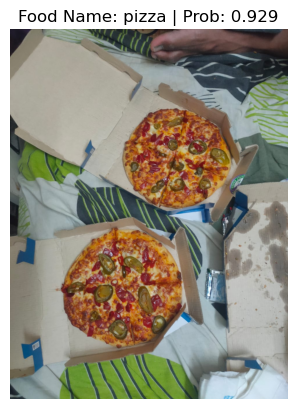

In [38]:
from PIL import Image

# open image
img = Image.open(data_path / "pizza_test_dominos.jpg")

# transformation
img_transf = transforms.Compose([transforms.Resize(size=(224,224)),
                                 transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

# predict the image

# make sure model is in target device
best_model.to(device)

# put in evaluation and inference mode
best_model.eval()
with torch.inference_mode():

    # transformed image
    transformed_image = img_transf(img).unsqueeze(dim=0) # since expects to be in batches

    # prediction
    img_pred = best_model(transformed_image.to(device))

    # logits -> probability
    img_prob = torch.softmax(img_pred, dim=1)

    # probability -> prediction label
    img_label = torch.argmax(img_prob, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Food Name: {class_names[img_label]} | Prob: {img_prob.max():.3f}")
    plt.axis(False);

We can see that the confidence in prediction is almost doubled by performing experimentation (0.552 -> 0.929). 